In [279]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import logging
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # For formatting axes if needed
import os # Import os module for directory operations
import re # Import re for cleaning filenames

# Suppress excessive logging and warnings
warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [280]:
raw_data = pd.read_excel('nuoc_ngoai.xlsx')
raw_data

,Thành phố (Quốc gia),2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),2019 (GDP Quốc gia),2020 (GDP Quốc gia),2021 (GDP Quốc gia),2022 (GDP Quốc gia),2023 (GDP Quốc gia),2019 (Growth rate),2020 (Growth rate),2021 (Growth rate),2022 (Growth rate),Average growth rate
0,Jakarta (Indonesia),199.0,189.8,203.7,202.6,225.9,1119.10,1059.10,1186.50,1319.10,1371.20,-0.053615,0.120291,0.111757,0.039497,0.054483
1,Bangkok (Thái Lan),173.8,150.0,155.0,149.0,154.0,543.98,500.46,506.26,495.65,514.97,-0.080003,0.011589,-0.020958,0.038979,-0.012598
2,Singapore (Singapore),376.9,349.5,434.1,498.5,501.4,376.90,349.50,434.10,498.50,501.40,-0.072698,0.242060,0.148353,0.005817,0.080883
3,Manila (Philippines),119.7,121.2,117.7,113.8,118.8,376.80,361.80,394.10,404.40,437.10,-0.039809,0.089276,0.026135,0.080861,0.039116
4,Kuala Lumpur (Malaysia),55.6,51.7,53.0,54.5,56.7,365.18,337.46,373.79,407.61,399.71,-0.075908,0.107657,0.090479,-0.019381,0.025712
5,Hong Kong (Trung Quốc),363.1,344.9,369.0,358.7,380.8,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108
6,Seoul (Hàn Quốc),374.0,370.0,405.0,412.0,421.0,1642.00,1631.00,1800.00,1674.00,1713.00,-0.006699,0.103617,-0.070000,0.023297,0.012554
7,Taipei (Đài Loan),91.0,90.0,98.0,100.0,105.0,610.00,635.00,773.00,772.00,755.00,0.040984,0.217323,-0.001294,-0.022021,0.058748
8,Bắc Kinh (Trung Quốc),511.6,484.0,547.0,671.9,672.0,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108
9,Thượng Hải (Trung Quốc),550.0,520.0,600.0,590.0,610.0,14280.00,14687.00,17820.00,17882.00,17795.00,0.028501,0.213318,0.003479,-0.004865,0.060108


In [281]:
hcm_data = pd.read_csv('hcm.csv')
hcm_data

,Năm,Quy mô GRDP (GDP) giá hiện hành HCM (New) (Đơn vị: Tỷ đồng) (Mã số: 10)
0,2019,2051780
1,2020,2055017
2,2021,2067397
3,2022,2346329
4,2023,2500589


In [282]:
hcm_data['TP. Hồ Chí Minh (Việt Nam)'] = hcm_data['Quy mô GRDP (GDP) giá hiện hành HCM (New) (Đơn vị: Tỷ đồng) (Mã số: 10)']
hcm_data = hcm_data[['Năm', 'TP. Hồ Chí Minh (Việt Nam)']]
hcm_data

,Năm,TP. Hồ Chí Minh (Việt Nam)
0,2019,2051780
1,2020,2055017
2,2021,2067397
3,2022,2346329
4,2023,2500589


In [283]:
# add (GRDP) to every value of ['Năm']
hcm_data['Năm'] = hcm_data['Năm'].astype(str) + ' (GRDP)'
hcm_data

,Năm,TP. Hồ Chí Minh (Việt Nam)
0,2019 (GRDP),2051780
1,2020 (GRDP),2055017
2,2021 (GRDP),2067397
3,2022 (GRDP),2346329
4,2023 (GRDP),2500589


In [284]:
hcm_data = hcm_data.transpose()
hcm_data

,0,1,2,3,4
Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
TP. Hồ Chí Minh (Việt Nam),2051780,2055017,2067397,2346329,2500589


In [285]:
hcm_data.columns = hcm_data.iloc[0]
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
TP. Hồ Chí Minh (Việt Nam),2051780,2055017,2067397,2346329,2500589


In [286]:
hcm_data = hcm_data.iloc[1:]
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
TP. Hồ Chí Minh (Việt Nam),2051780,2055017,2067397,2346329,2500589


In [287]:
hcm_data['Thành phố (Quốc gia)'] = 'TP. Hồ Chí Minh (Việt Nam)'

In [288]:
hcm_data.index = [13]
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),Thành phố (Quốc gia)
13,2051780,2055017,2067397,2346329,2500589,TP. Hồ Chí Minh (Việt Nam)


In [289]:
cols_to_divide = hcm_data.columns.drop('Thành phố (Quốc gia)')
hcm_data[cols_to_divide] = hcm_data[cols_to_divide] / 26000
hcm_data

Năm,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),Thành phố (Quốc gia)
13,78.914615,79.039115,79.515269,90.243423,96.1765,TP. Hồ Chí Minh (Việt Nam)


In [290]:
cities_grdp_cols = ['Thành phố (Quốc gia)', '2019 (GRDP)', '2020 (GRDP)', '2021 (GRDP)', '2022 (GRDP)', '2023 (GRDP)']
country_gdp_cols = ['Thành phố (Quốc gia)', '2019 (GDP Quốc gia)', '2020 (GDP Quốc gia)', '2021 (GDP Quốc gia)', '2022 (GDP Quốc gia)', '2023 (GDP Quốc gia)']
growth_cols = ['Thành phố (Quốc gia)', '2019 (Growth rate)', '2020 (Growth rate)', '2021 (Growth rate)', '2022 (Growth rate)', 'Average growth rate']

In [291]:
cities_grdp_df = raw_data.loc[:, cities_grdp_cols]
country_gdp_df = raw_data.loc[:, country_gdp_cols]
growth_df = raw_data.loc[:, growth_cols]

In [292]:
cities_grdp_df

,Thành phố (Quốc gia),2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP)
0,Jakarta (Indonesia),199.0,189.8,203.7,202.6,225.9
1,Bangkok (Thái Lan),173.8,150.0,155.0,149.0,154.0
2,Singapore (Singapore),376.9,349.5,434.1,498.5,501.4
3,Manila (Philippines),119.7,121.2,117.7,113.8,118.8
4,Kuala Lumpur (Malaysia),55.6,51.7,53.0,54.5,56.7
5,Hong Kong (Trung Quốc),363.1,344.9,369.0,358.7,380.8
6,Seoul (Hàn Quốc),374.0,370.0,405.0,412.0,421.0
7,Taipei (Đài Loan),91.0,90.0,98.0,100.0,105.0
8,Bắc Kinh (Trung Quốc),511.6,484.0,547.0,671.9,672.0
9,Thượng Hải (Trung Quốc),550.0,520.0,600.0,590.0,610.0


In [293]:
cities_grdp_df = pd.concat([hcm_data, cities_grdp_df]).reset_index(drop=True)
cities_grdp_df

,2019 (GRDP),2020 (GRDP),2021 (GRDP),2022 (GRDP),2023 (GRDP),Thành phố (Quốc gia)
0,78.914615,79.039115,79.515269,90.243423,96.1765,TP. Hồ Chí Minh (Việt Nam)
1,199.0,189.8,203.7,202.6,225.9,Jakarta (Indonesia)
2,173.8,150.0,155.0,149.0,154.0,Bangkok (Thái Lan)
3,376.9,349.5,434.1,498.5,501.4,Singapore (Singapore)
4,119.7,121.2,117.7,113.8,118.8,Manila (Philippines)
5,55.6,51.7,53.0,54.5,56.7,Kuala Lumpur (Malaysia)
6,363.1,344.9,369.0,358.7,380.8,Hong Kong (Trung Quốc)
7,374.0,370.0,405.0,412.0,421.0,Seoul (Hàn Quốc)
8,91.0,90.0,98.0,100.0,105.0,Taipei (Đài Loan)
9,511.6,484.0,547.0,671.9,672.0,Bắc Kinh (Trung Quốc)


In [294]:
new_columns = {col: col.replace(' (GRDP)', '') for col in cities_grdp_df.columns if '(GRDP)' in col}
cities_grdp_df = cities_grdp_df.rename(columns=new_columns)
cities_grdp_df

,2019,2020,2021,2022,2023,Thành phố (Quốc gia)
0,78.914615,79.039115,79.515269,90.243423,96.1765,TP. Hồ Chí Minh (Việt Nam)
1,199.0,189.8,203.7,202.6,225.9,Jakarta (Indonesia)
2,173.8,150.0,155.0,149.0,154.0,Bangkok (Thái Lan)
3,376.9,349.5,434.1,498.5,501.4,Singapore (Singapore)
4,119.7,121.2,117.7,113.8,118.8,Manila (Philippines)
5,55.6,51.7,53.0,54.5,56.7,Kuala Lumpur (Malaysia)
6,363.1,344.9,369.0,358.7,380.8,Hong Kong (Trung Quốc)
7,374.0,370.0,405.0,412.0,421.0,Seoul (Hàn Quốc)
8,91.0,90.0,98.0,100.0,105.0,Taipei (Đài Loan)
9,511.6,484.0,547.0,671.9,672.0,Bắc Kinh (Trung Quốc)


In [295]:
cities_grdp_df = pd.read_excel('tong_hop.xlsx')
cities_grdp_df

,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Bắc Kinh (Trung Quốc),Thượng Hải (Trung Quốc),Thâm Quyến (Trung Quốc),Tokyo (Nhật Bản),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
0,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,511.6,550,381.4,1061.3,377.9,78.914615
1,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,484.0,520,374.0,1020.0,350.0,79.039115
2,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,547.0,600,450.0,990.0,330.0,79.515269
3,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,671.9,590,470.0,920.0,300.0,90.243423
4,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,672.0,610,500.0,890.0,290.0,96.176500


In [296]:
cities_grdp_df.set_index('Năm',inplace=True, drop=False)
cities_grdp_df


,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Bắc Kinh (Trung Quốc),Thượng Hải (Trung Quốc),Thâm Quyến (Trung Quốc),Tokyo (Nhật Bản),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
Năm,,,,,,,,,,,,,,,
2019,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,511.6,550,381.4,1061.3,377.9,78.914615
2020,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,484.0,520,374.0,1020.0,350.0,79.039115
2021,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,547.0,600,450.0,990.0,330.0,79.515269
2022,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,671.9,590,470.0,920.0,300.0,90.243423
2023,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,672.0,610,500.0,890.0,290.0,96.176500


In [297]:
average_growth_df = growth_df[['Thành phố (Quốc gia)', 'Average growth rate']]
average_growth_df

,Thành phố (Quốc gia),Average growth rate
0,Jakarta (Indonesia),0.054483
1,Bangkok (Thái Lan),-0.012598
2,Singapore (Singapore),0.080883
3,Manila (Philippines),0.039116
4,Kuala Lumpur (Malaysia),0.025712
5,Hong Kong (Trung Quốc),0.060108
6,Seoul (Hàn Quốc),0.012554
7,Taipei (Đài Loan),0.058748
8,Bắc Kinh (Trung Quốc),0.060108
9,Thượng Hải (Trung Quốc),0.060108


In [298]:
forecast_years = np.arange(2024, 2031).reshape(-1, 1)
forecast_years

array([[2024],
       [2025],
       [2026],
       [2027],
       [2028],
       [2029],
       [2030]])

In [299]:
def forecast_linear_regression(series: pd.Series):
    """Forecasts using Linear Regression based on Year."""
    df = series.reset_index()
    df.columns = ['Năm', 'Value']

    # Prepare data for sklearn
    X_train = df['Năm'].values.reshape(-1, 1)
    y_train = df['Value'].values

    # Handle potential NaN/inf values if any exist before fitting
    if not np.all(np.isfinite(y_train)):
         print(f"Warning: Non-finite values found in series {series.name}. Skipping linear regression.")
         return pd.Series(index=forecast_years.flatten(), dtype=float)


    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict
    predictions = model.predict(forecast_years)
    return pd.Series(predictions, index=forecast_years.flatten())

def forecast_fixed_growth(series: pd.Series, growth_rate: float = 0.08):
    """
    Forecasts assuming a fixed compound annual growth rate from the last value.
    
    Args:
        series: Input time series to forecast
        growth_rate: Annual growth rate as a decimal (e.g. 0.08 for 8% growth)
    """
    # Get the last value directly without using loc with the index
    last_value = series.iloc[-1]
    last_year = int(series.index.max())  # Convert to int for calculation

    if not np.isfinite(last_value):
        print(f"Warning: Last value for {series.name} is non-finite. Cannot apply growth forecast.")
        return pd.Series(index=forecast_years.flatten(), dtype=float)

    forecast_values = [
        last_value * ((1 + growth_rate) ** (int(year) - last_year))
        for year in forecast_years.flatten()
    ]
    return pd.Series(forecast_values, index=forecast_years.flatten())

def forecast_exponential_smoothing(series: pd.Series) -> pd.Series:
    """Forecast using Exponential Smoothing Regression."""
    df = series.reset_index()
    df.columns = ['Năm', 'Value']

    # Use a simple additive trend component (no seasonality)
    model = ExponentialSmoothing(
        df['Value'], 
        trend='add',  # Additive trend component
        seasonal=None  # No seasonal component due to limited data
    ).fit()

    # Forecast the next values
    forecast_values = model.forecast(len(forecast_years))
    return forecast_values
    
def forecast_arima(series: pd.Series) -> pd.Series:
    """
    Forecast a time series with ARIMA.
    Falls back to a simpler (0,d,0) model if the default (1,d,1) fails.

    Returns a Series whose index == forecast_years.
    If the series is unusable, returns an all-NaN Series with the same index.
    """
    y = series.copy()
    d = 0

    if y.std() > 1e-9 and adfuller(y)[1] > 0.05:
        d = 1
        diff = y.diff().dropna()
        if diff.std() > 1e-9 and adfuller(diff)[1] > 0.05:
            d = 2

    for order in [(1, d, 1), (0, d, 0)]:
        try:
            fit = ARIMA(
                y, order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit()
            fc = fit.get_forecast(len(forecast_years)).predicted_mean
            fc.index = forecast_years.flatten()
            return fc
        except Exception:
            continue

    return pd.Series(index=forecast_years, dtype=float)


def forecast_prophet(series: pd.Series):
    """Forecasts using Facebook Prophet."""
    df = series.reset_index()
    df.columns = ['Năm', 'y']
    df['ds'] = pd.to_datetime(df['Năm'].astype(str) + '-12-31') # Use year-end for annual data

     # Handle potential NaN/inf values
    if not np.all(np.isfinite(df['y'].values)):
         print(f"Warning: Non-finite values found in series {series.name}. Skipping Prophet.")
         return pd.Series(index=forecast_years.flatten(), dtype=float)


    try:
        model = Prophet(growth='linear', yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
        model.fit(df[['ds', 'y']])

        # Create future dataframe
        future_dates = model.make_future_dataframe(periods=len(forecast_years), freq='A-DEC') # Annual frequency ending Dec 31st
        # Adjust future dates to match target years if needed
        future_dates['year'] = future_dates['ds'].dt.year
        future_dates = future_dates[future_dates['year'].isin(forecast_years.flatten())]


        # Predict
        forecast_result = model.predict(future_dates)
        predictions = forecast_result[['ds', 'yhat']].set_index('ds')['yhat']
        predictions.index = predictions.index.year # Use year as index
        # Ensure all forecast years are present, filling missing ones potentially with NaN
        predictions = predictions.reindex(forecast_years.flatten())
        return predictions
    except Exception as e:
        print(f"Error fitting Prophet for {series.name}: {e}")
        return pd.Series(index=forecast_years.flatten(), dtype=float)

In [300]:
cities_grdp_df

,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Bắc Kinh (Trung Quốc),Thượng Hải (Trung Quốc),Thâm Quyến (Trung Quốc),Tokyo (Nhật Bản),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
Năm,,,,,,,,,,,,,,,
2019,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,511.6,550,381.4,1061.3,377.9,78.914615
2020,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,484.0,520,374.0,1020.0,350.0,79.039115
2021,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,547.0,600,450.0,990.0,330.0,79.515269
2022,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,671.9,590,470.0,920.0,300.0,90.243423
2023,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,672.0,610,500.0,890.0,290.0,96.176500


In [301]:
features_to_forecast = cities_grdp_df.columns.drop(['Năm'])
features_to_forecast

Index(['Jakarta (Indonesia)', 'Bangkok (Thái Lan)', 'Singapore (Singapore)',
       'Manila (Philippines)', 'Kuala Lumpur (Malaysia)',
       'Hong Kong (Trung Quốc)', 'Seoul (Hàn Quốc)', 'Taipei (Đài Loan)',
       'Bắc Kinh (Trung Quốc)', 'Thượng Hải (Trung Quốc)',
       'Thâm Quyến (Trung Quốc)', 'Tokyo (Nhật Bản)', 'Osaka (Nhật Bản)',
       'TP. Hồ Chí Minh (Việt Nam)'],
      dtype='object')

In [302]:
all_inputs = {'foreign_regression': cities_grdp_df}
all_inputs

{'foreign_regression':        Năm  Jakarta (Indonesia)  Bangkok (Thái Lan)  Singapore (Singapore)  \
 Năm                                                                          
 2019  2019                199.0               173.8                  376.9   
 2020  2020                189.8               150.0                  349.5   
 2021  2021                203.7               155.0                  434.1   
 2022  2022                202.6               149.0                  498.5   
 2023  2023                225.9               154.0                  501.4   
 
       Manila (Philippines)  Kuala Lumpur (Malaysia)  Hong Kong (Trung Quốc)  \
 Năm                                                                           
 2019                 119.7                     55.6                   363.1   
 2020                 121.2                     51.7                   344.9   
 2021                 117.7                     53.0                   369.0   
 2022                 1

In [303]:
all_forecasts = {}

In [304]:
# Create a list of features that should be clipped at 0 (non-negative values only)
for name, df in all_inputs.items():
    print(f"--- Forecasting for {name} ---")
    forecasts_by_feature = {}

    # set Năm as integer index and sort
    df_i = df.set_index('Năm').sort_index()

    for feature in features_to_forecast:
        print(f"   Forecasting {feature}...")
        s = df_i[feature].astype(float)

        # skip constant or all‑NaN series
        if s.nunique() <= 1 or not np.any(np.isfinite(s)):
            print(f"      Skipping {feature} for {name}: constant or non‑finite.")
            empty = pd.DataFrame(index=forecast_years.flatten(), 
                                 columns=['Linear Regression','Prophet','10% Growth','8% Growth','Mixed Growth','ARIMA'])
            forecasts_by_feature[feature] = empty
            continue

        # otherwise, do all methods
        df_fc = pd.DataFrame(index=forecast_years.flatten())
        
        # 1) Linear Regression
        lr = forecast_linear_regression(s)
        df_fc['Linear Regression'] = lr

        # 2) Prophet
        pr = forecast_prophet(s)
        df_fc['Prophet'] = pr

        # 3) 10% growth
        g10 = forecast_fixed_growth(s, growth_rate=0.1)
        df_fc['10% Growth'] = g10

        # 4) fixed growth based on city's country average growth rate
        # Get the city name from the feature
        city_name = feature
        # Find the corresponding growth rate from average_growth_df
        if city_name in average_growth_df['Thành phố (Quốc gia)'].values:
            growth_rate = average_growth_df.loc[average_growth_df['Thành phố (Quốc gia)'] == city_name, 'Average growth rate'].values[0]
        else:
            # Default growth rate if city not found
            growth_rate = 0.08
            print(f"      Warning: No growth rate found for {city_name}, using default 8%")
        
        fg = forecast_fixed_growth(s, growth_rate=growth_rate)
        df_fc['Fixed Growth'] = fg

        # 6) Exponential Smoothing
        es = forecast_exponential_smoothing(s)
        df_fc['Exponential Smoothing'] = es.values

        # 7) ARIMA
        # try:
        #     s_period = s.copy()
        #     s_period.index = pd.PeriodIndex(s_period.index, freq='A-DEC', name='Năm')
        #     ar = forecast_arima(s_period)
        #     df_fc['ARIMA'] = ar
        # except Exception as e:
        #     print(f"ARIMA failed for {feature} in {name}: {e}")
        #     df_fc['ARIMA'] = np.nan

        forecasts_by_feature[feature] = df_fc

    # concatenate each feature's DataFrame side by side
    all_forecasts[name] = pd.concat(forecasts_by_feature, axis=1)

print("\n--- All forecasting complete ---")

--- Forecasting for foreign_regression ---
   Forecasting Jakarta (Indonesia)...
   Forecasting Bangkok (Thái Lan)...
   Forecasting Singapore (Singapore)...
   Forecasting Manila (Philippines)...
   Forecasting Kuala Lumpur (Malaysia)...
   Forecasting Hong Kong (Trung Quốc)...
   Forecasting Seoul (Hàn Quốc)...
   Forecasting Taipei (Đài Loan)...
   Forecasting Bắc Kinh (Trung Quốc)...
   Forecasting Thượng Hải (Trung Quốc)...
   Forecasting Thâm Quyến (Trung Quốc)...
   Forecasting Tokyo (Nhật Bản)...
   Forecasting Osaka (Nhật Bản)...
   Forecasting TP. Hồ Chí Minh (Việt Nam)...

--- All forecasting complete ---


In [305]:
all_forecasts

{'foreign_regression':      Jakarta (Indonesia)                                       \
        Linear Regression     Prophet  10% Growth Fixed Growth   
 2024              224.18  224.178107  248.490000   238.207608   
 2025              230.84  230.829479  273.339000   251.185766   
 2026              237.50  237.480850  300.672900   264.871006   
 2027              244.16  244.132222  330.740190   279.301854   
 2028              250.82  250.801817  363.814209   294.518931   
 2029              257.48  257.453189  400.195630   310.565073   
 2030              264.14  264.104561  440.215193   327.485450   
 
                            Bangkok (Thái Lan)                          \
      Exponential Smoothing  Linear Regression     Prophet  10% Growth   
 2024            224.180001             144.18  144.182796  169.400000   
 2025            230.840001             140.12  140.128186  186.340000   
 2026            237.500001             136.06  136.073576  204.974000   
 2027       

In [306]:
# Define the output directory
output_dir = 'output_plots_with_table' # Keep same directory
os.makedirs(output_dir, exist_ok=True)

In [307]:
models_for_table = ['Historical','Linear Regression', '10% Growth', 'Fixed Growth', 'Exponential Smoothing', 'Prophet']

In [308]:
# Define colors for different models
colors = {
    'Historical': 'black',
    'Linear Regression': 'blue',
    '10% Growth': 'red',
    'Fixed Growth': 'yellow',
    'Exponential Smoothing': 'green',
    'Prophet': 'brown'
}

In [309]:
cities_grdp_df

,Năm,Jakarta (Indonesia),Bangkok (Thái Lan),Singapore (Singapore),Manila (Philippines),Kuala Lumpur (Malaysia),Hong Kong (Trung Quốc),Seoul (Hàn Quốc),Taipei (Đài Loan),Bắc Kinh (Trung Quốc),Thượng Hải (Trung Quốc),Thâm Quyến (Trung Quốc),Tokyo (Nhật Bản),Osaka (Nhật Bản),TP. Hồ Chí Minh (Việt Nam)
Năm,,,,,,,,,,,,,,,
2019,2019,199.0,173.8,376.9,119.7,55.6,363.1,374,91,511.6,550,381.4,1061.3,377.9,78.914615
2020,2020,189.8,150.0,349.5,121.2,51.7,344.9,370,90,484.0,520,374.0,1020.0,350.0,79.039115
2021,2021,203.7,155.0,434.1,117.7,53.0,369.0,405,98,547.0,600,450.0,990.0,330.0,79.515269
2022,2022,202.6,149.0,498.5,113.8,54.5,358.7,412,100,671.9,590,470.0,920.0,300.0,90.243423
2023,2023,225.9,154.0,501.4,118.8,56.7,380.8,421,105,672.0,610,500.0,890.0,290.0,96.176500



Processing plots for: foreign_regression
  Saved plot with table: output_plots_with_table\foreign_regression_Jakarta_Indonesia_with_table.png


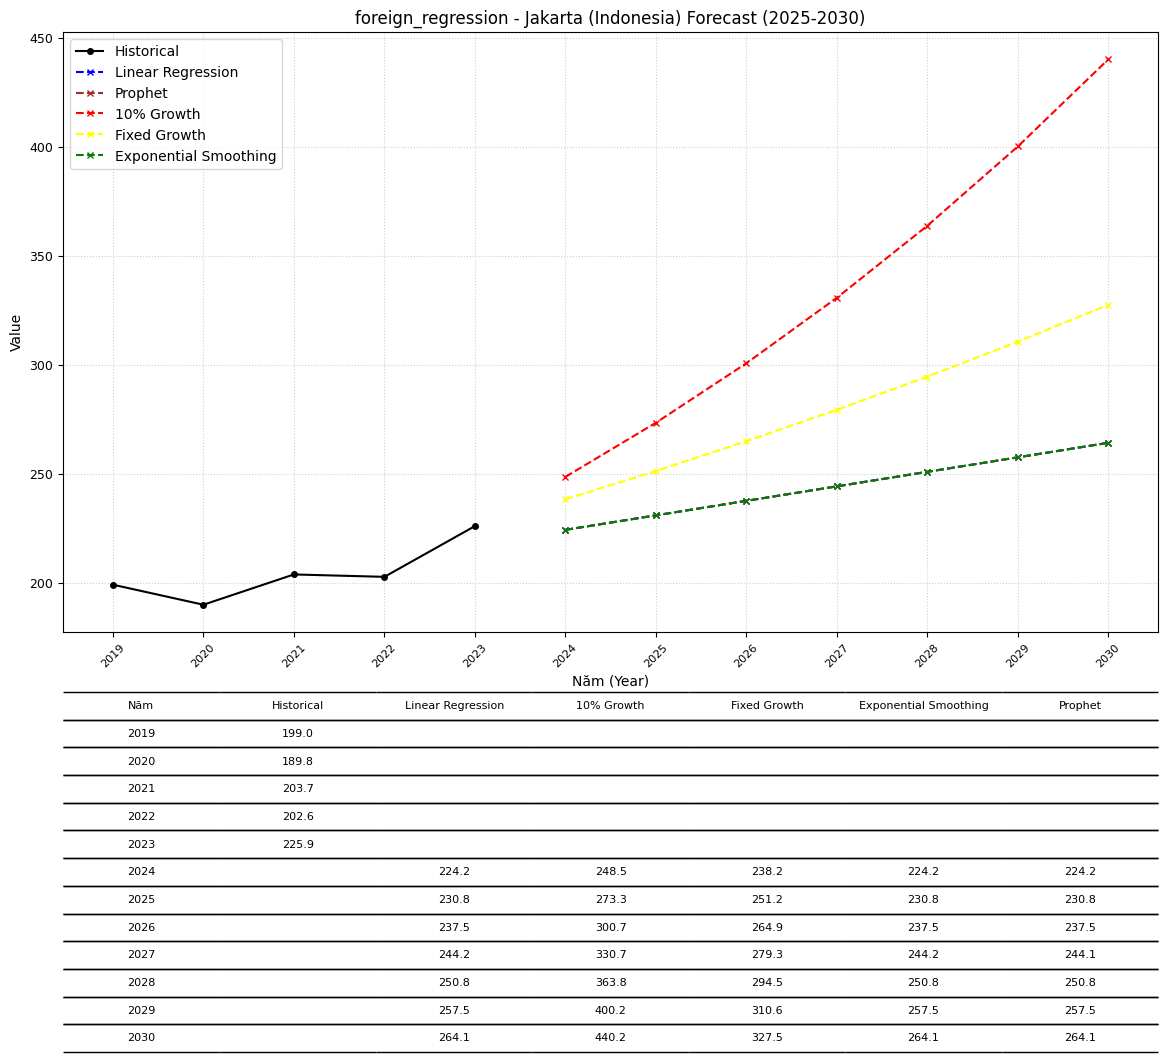

  Saved plot with table: output_plots_with_table\foreign_regression_Bangkok_Thái_Lan_with_table.png


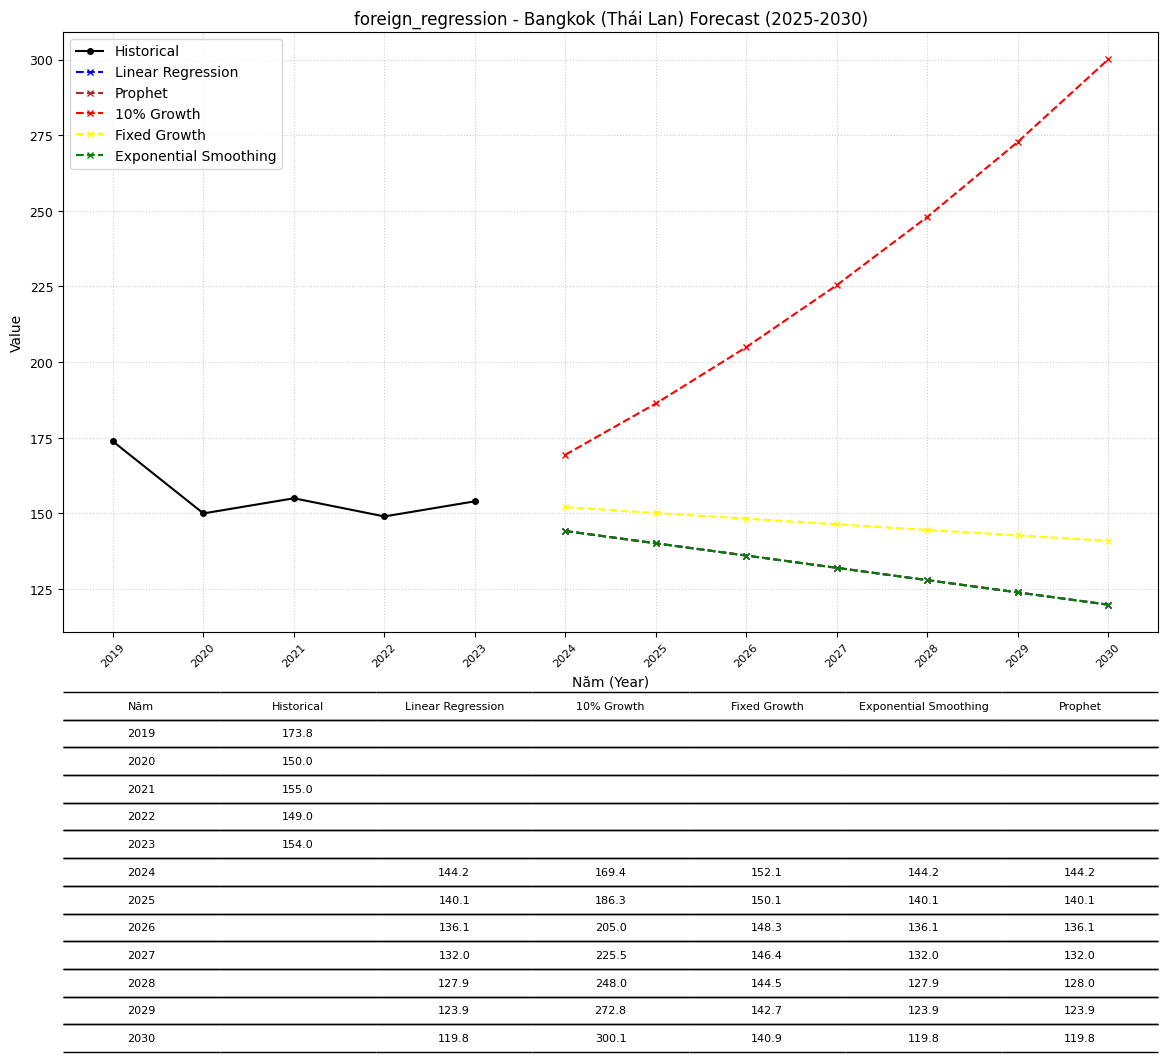

  Saved plot with table: output_plots_with_table\foreign_regression_Singapore_Singapore_with_table.png


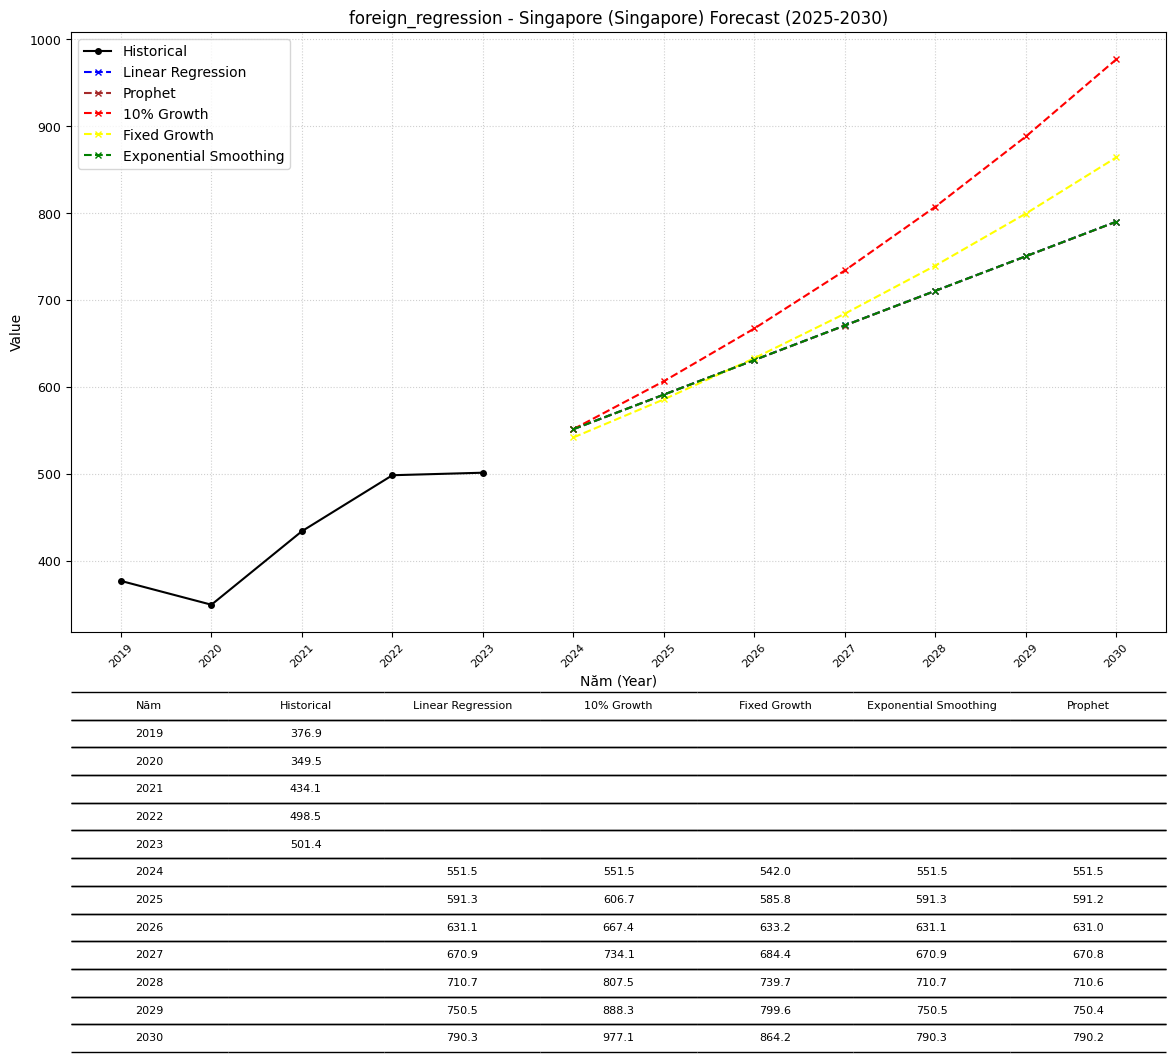

  Saved plot with table: output_plots_with_table\foreign_regression_Manila_Philippines_with_table.png


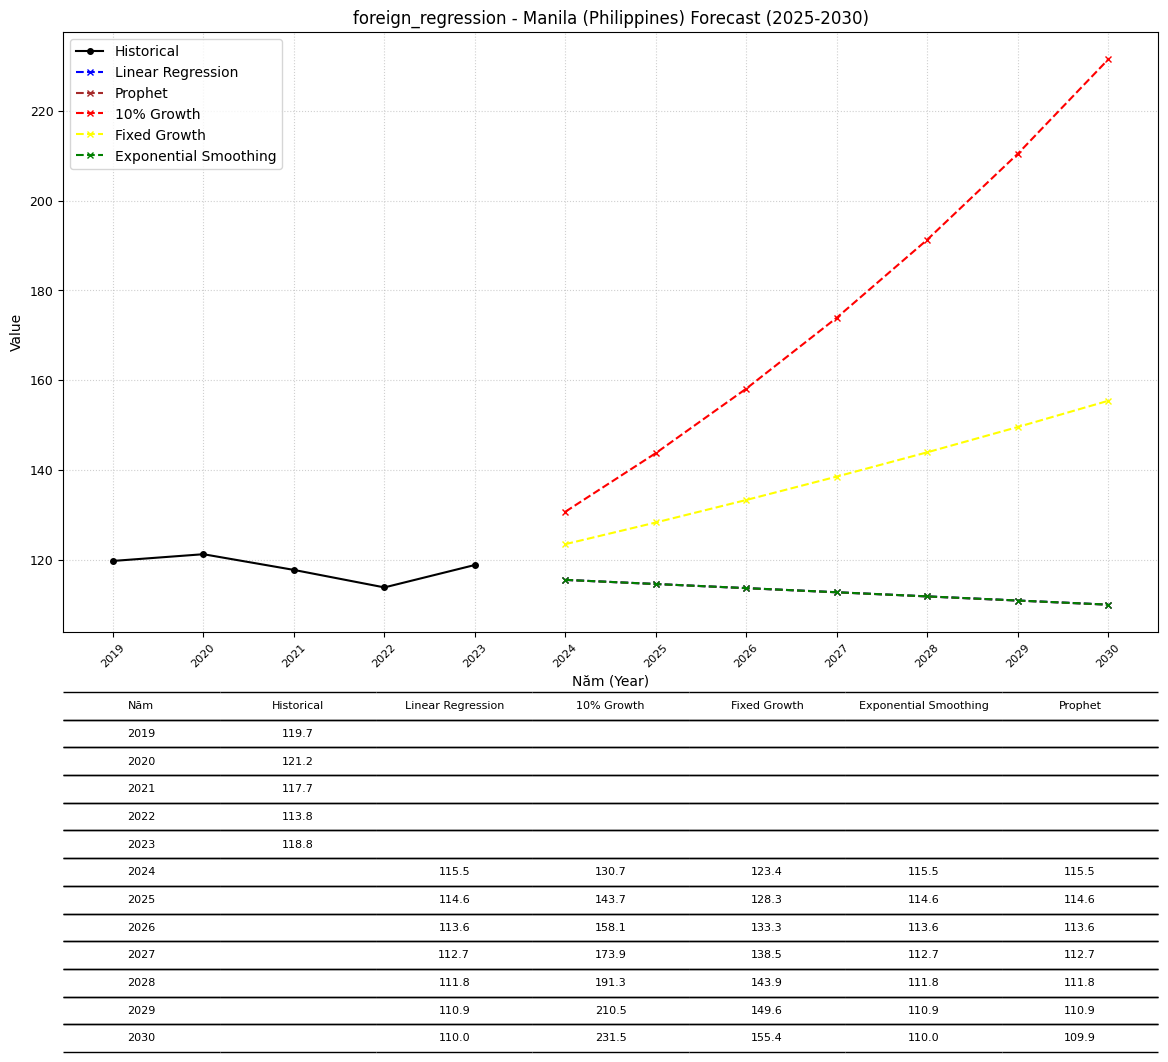

  Saved plot with table: output_plots_with_table\foreign_regression_Kuala_Lumpur_Malaysia_with_table.png


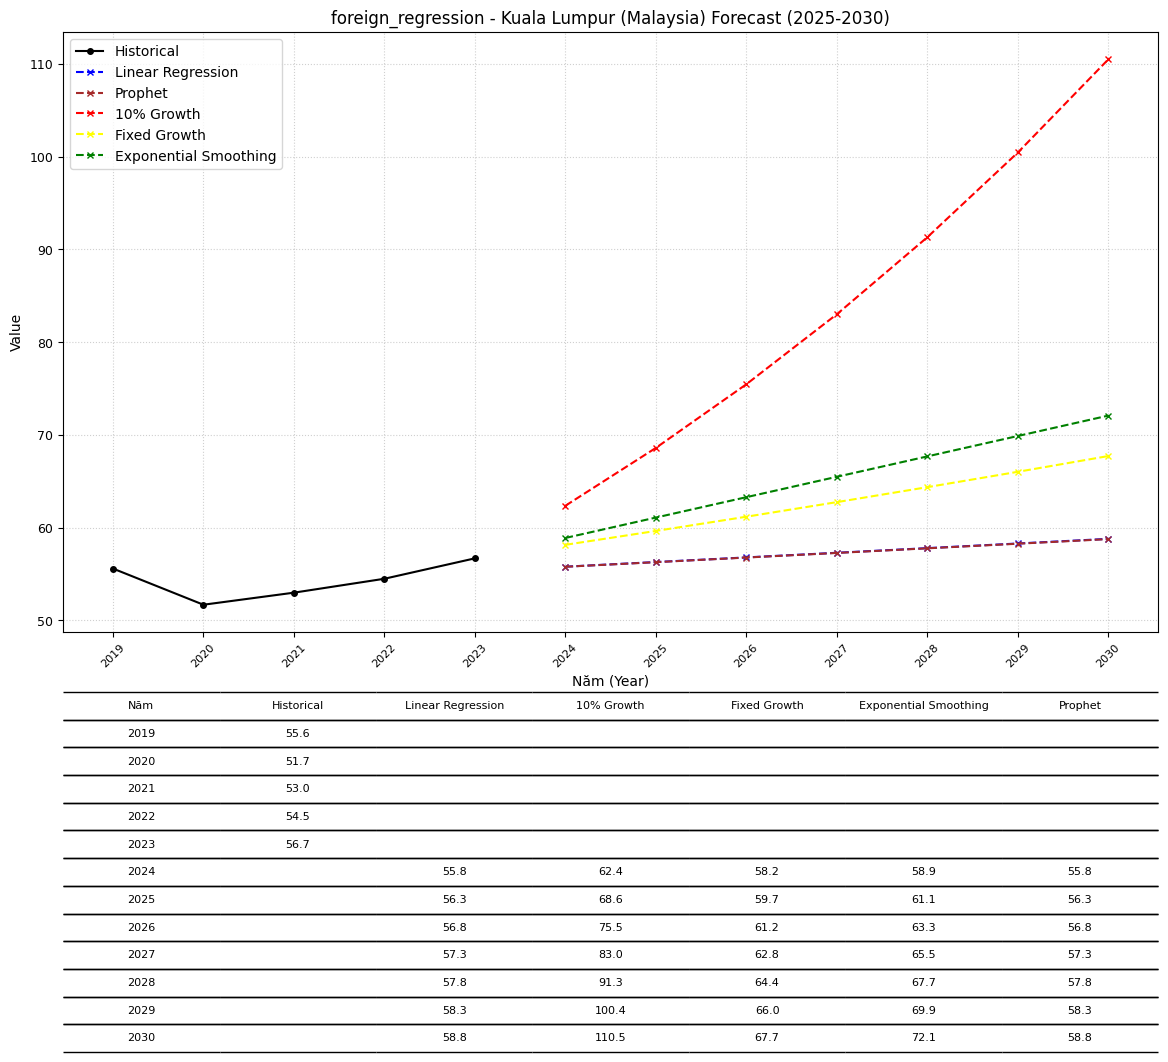

  Saved plot with table: output_plots_with_table\foreign_regression_Hong_Kong_Trung_Quốc_with_table.png


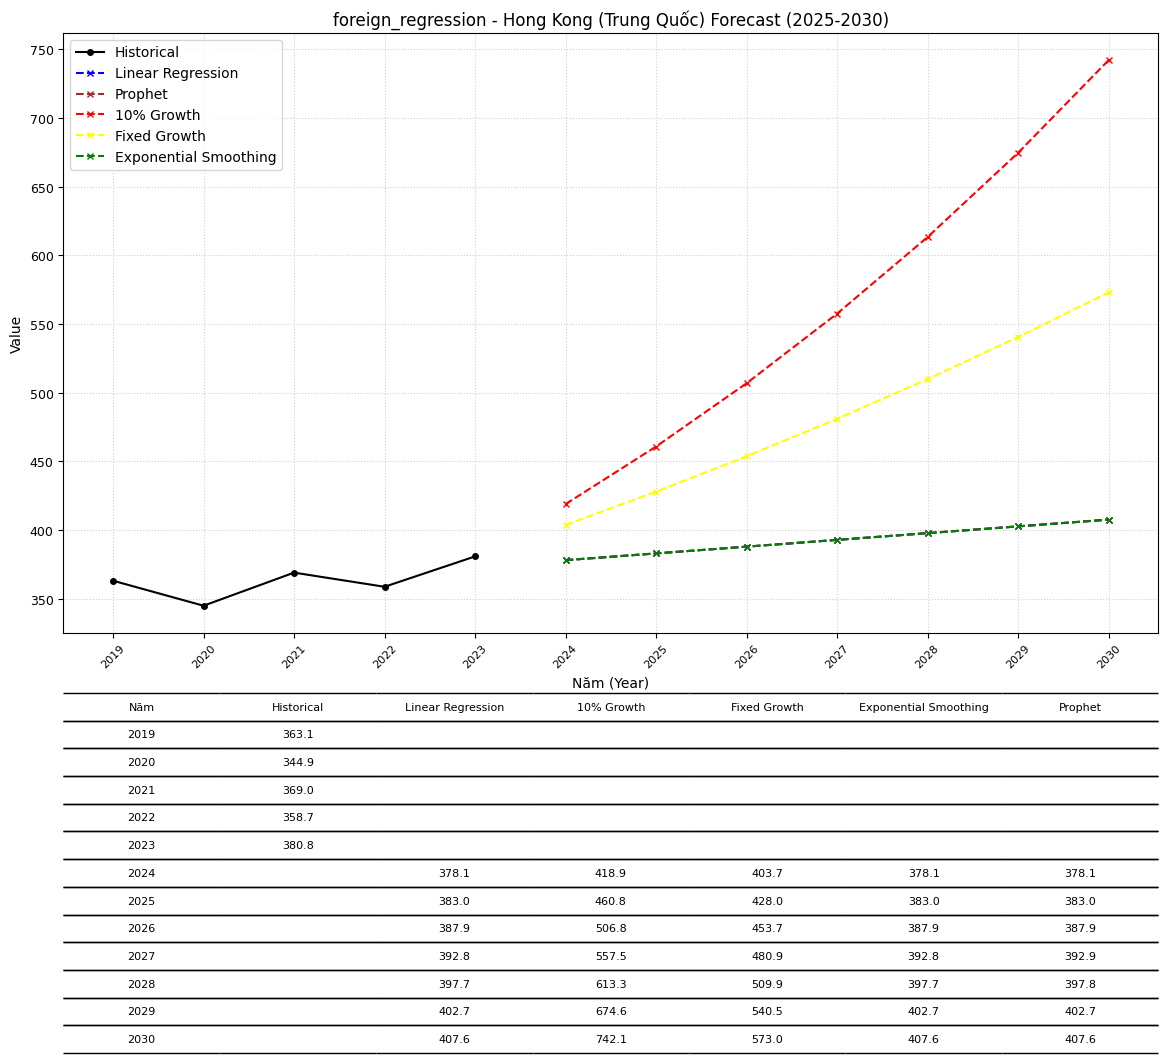

  Saved plot with table: output_plots_with_table\foreign_regression_Seoul_Hàn_Quốc_with_table.png


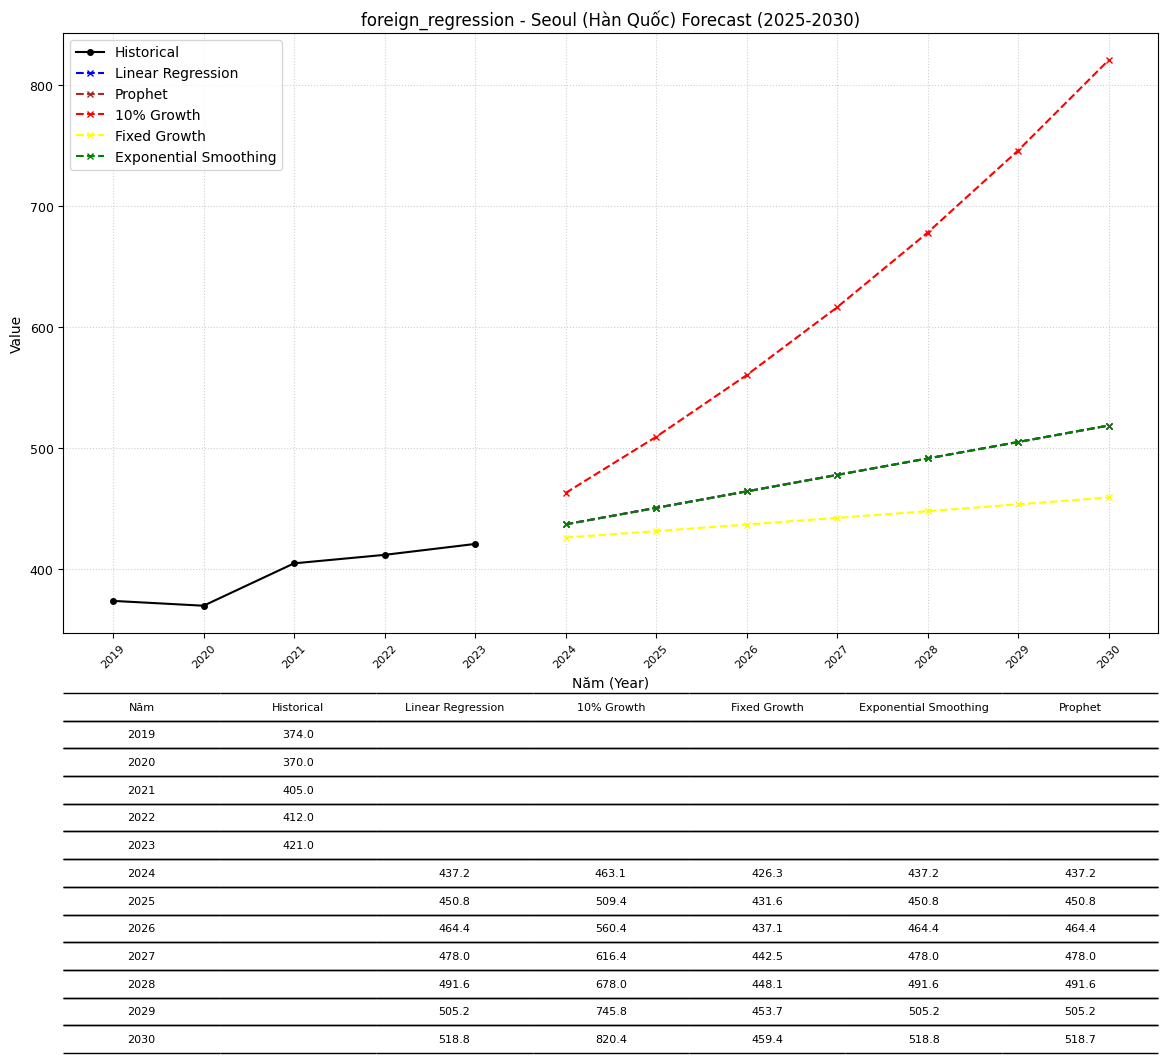

  Saved plot with table: output_plots_with_table\foreign_regression_Taipei_Đài_Loan_with_table.png


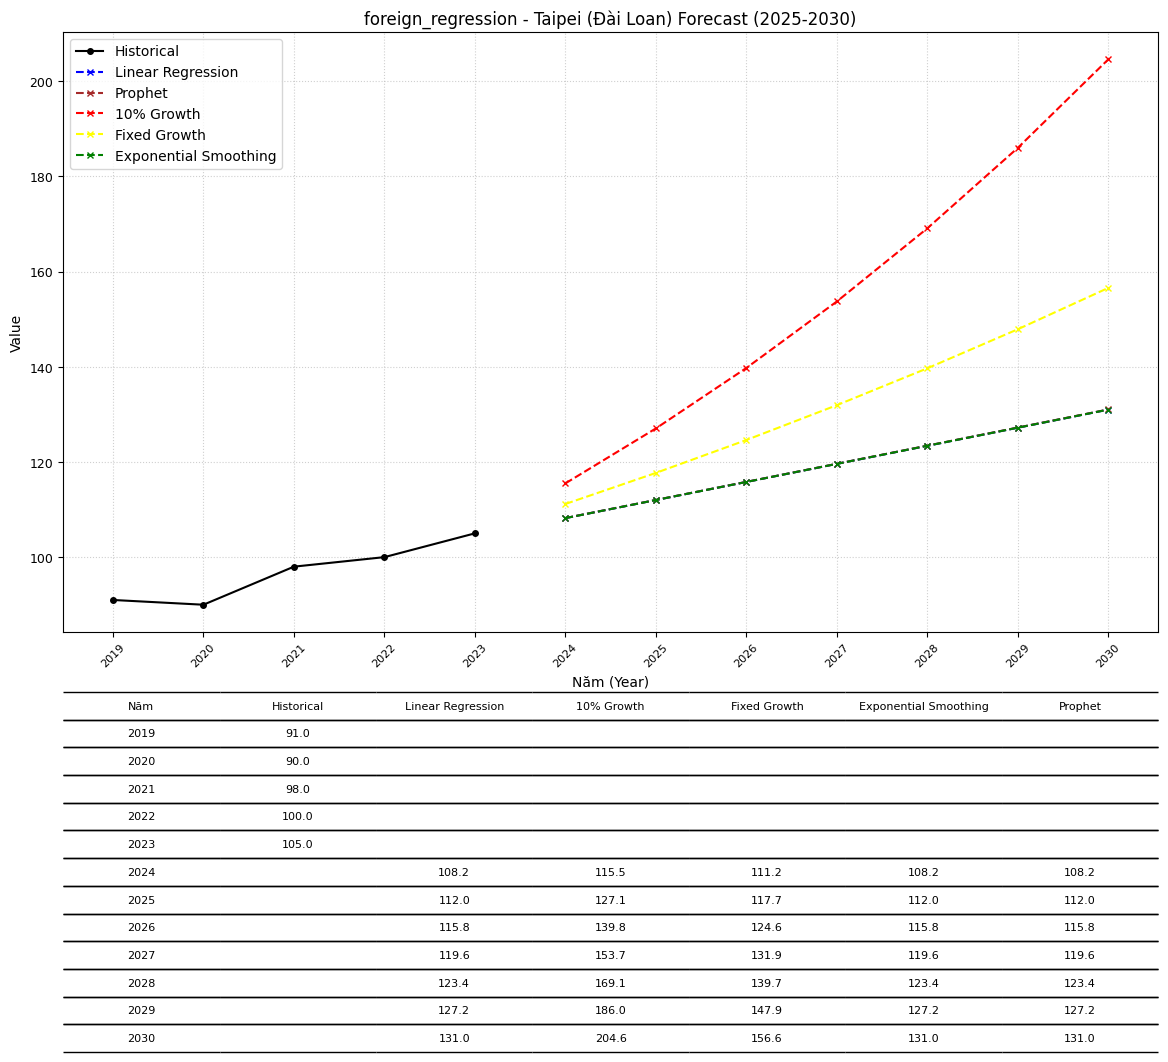

  Saved plot with table: output_plots_with_table\foreign_regression_Bắc_Kinh_Trung_Quốc_with_table.png


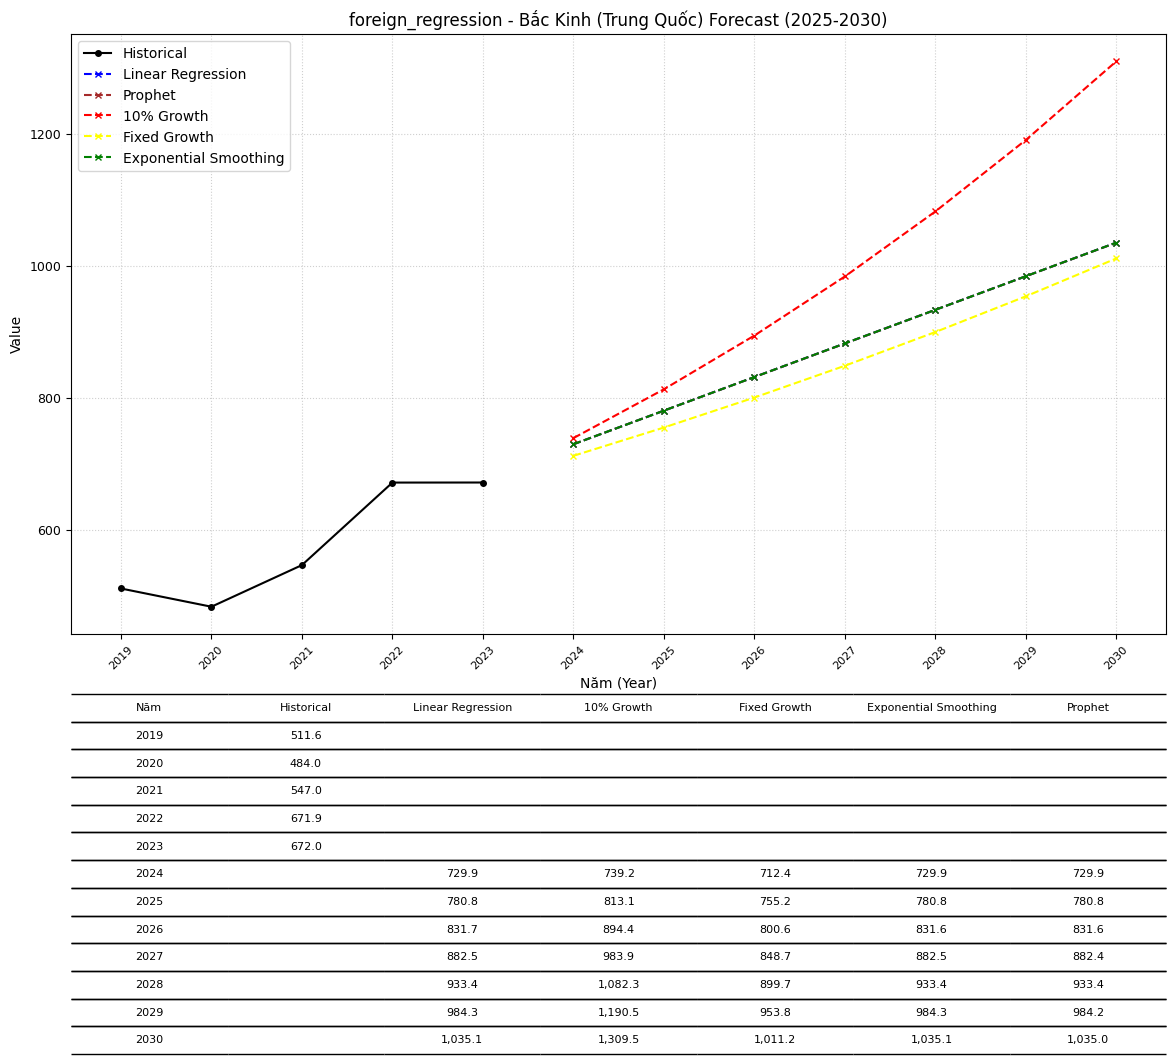

  Saved plot with table: output_plots_with_table\foreign_regression_Thượng_Hải_Trung_Quốc_with_table.png


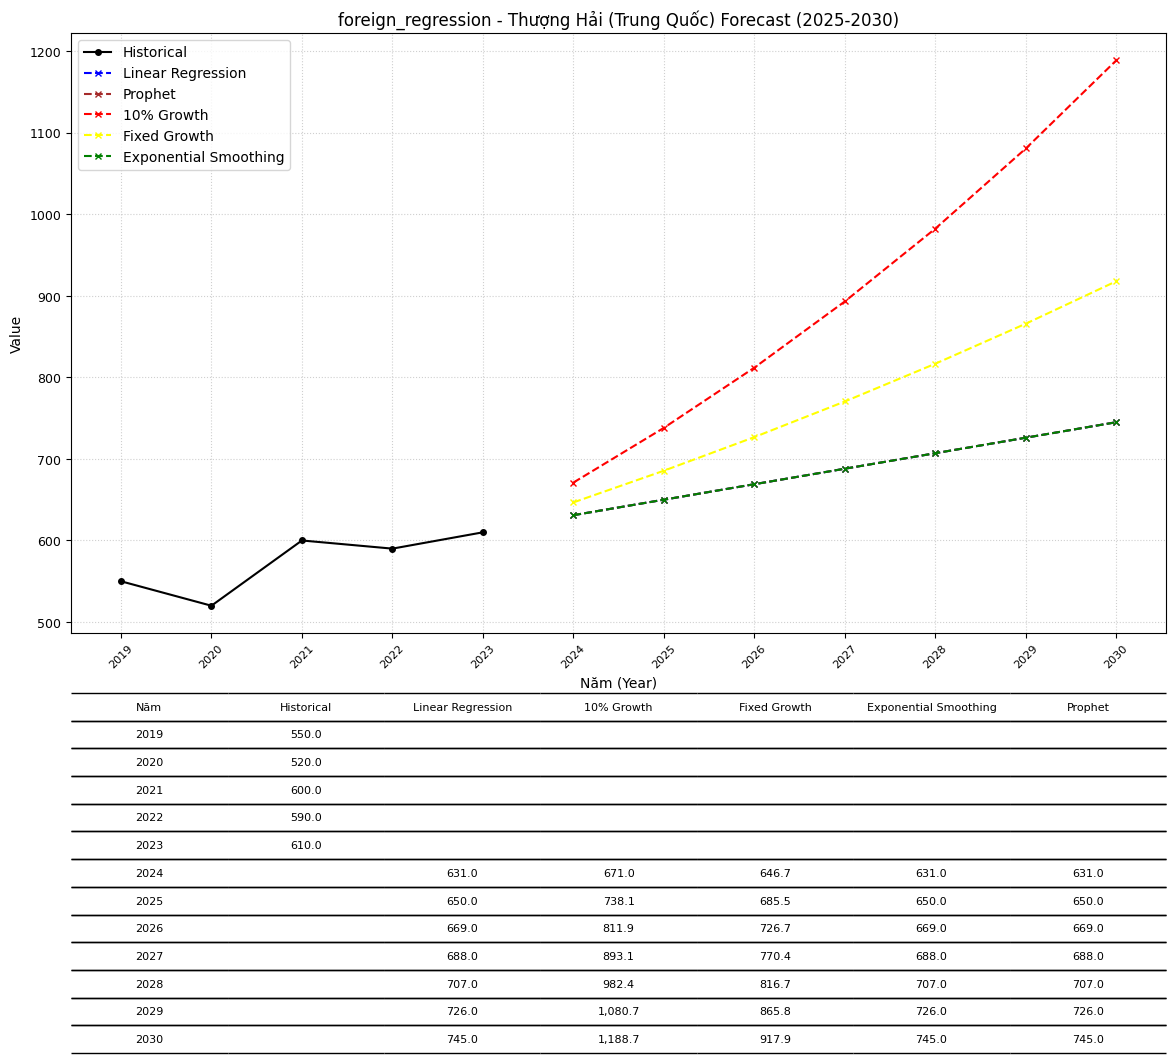

  Saved plot with table: output_plots_with_table\foreign_regression_Thâm_Quyến_Trung_Quốc_with_table.png


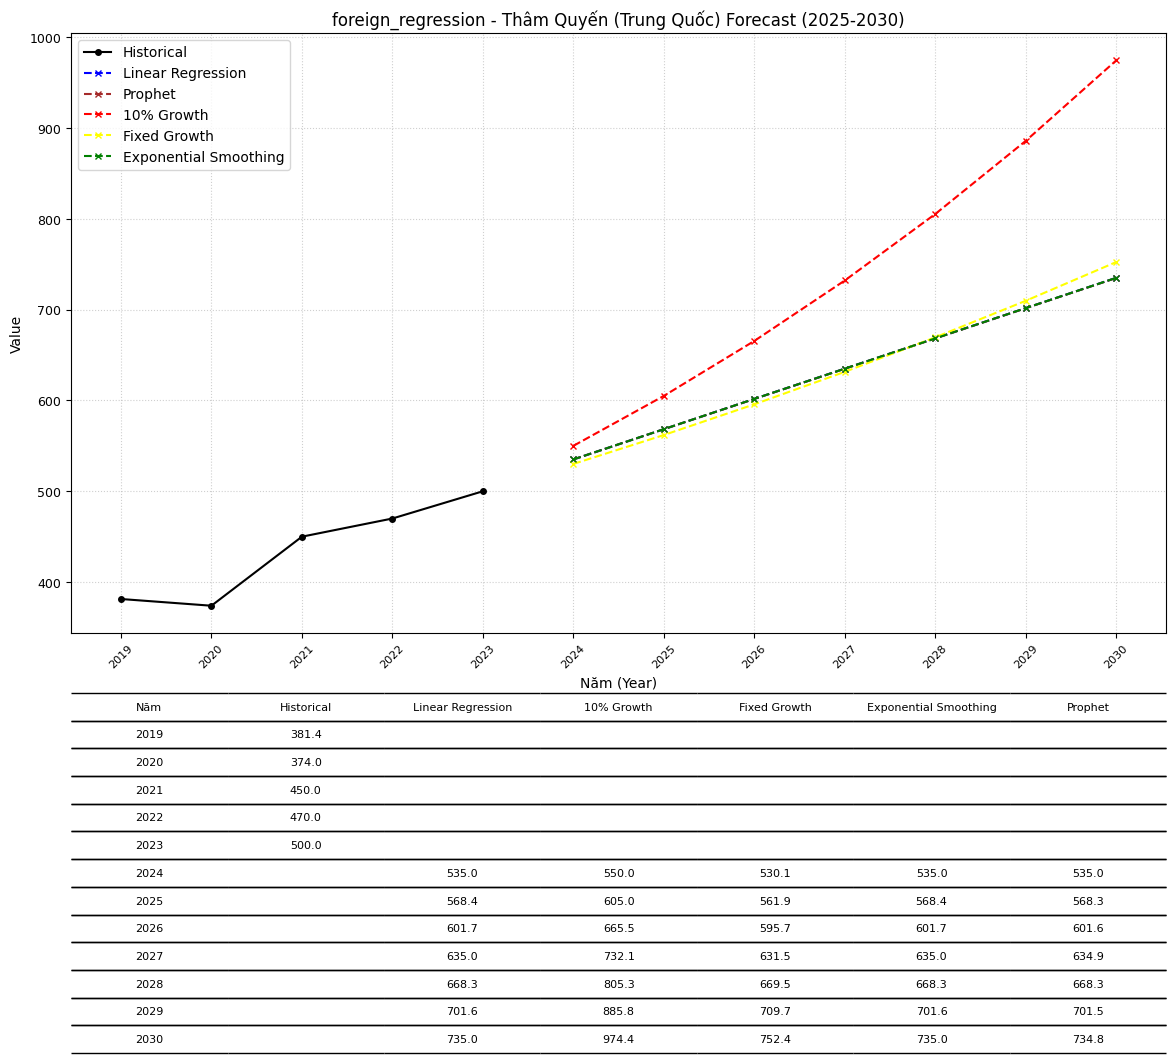

  Saved plot with table: output_plots_with_table\foreign_regression_Tokyo_Nhật_Bản_with_table.png


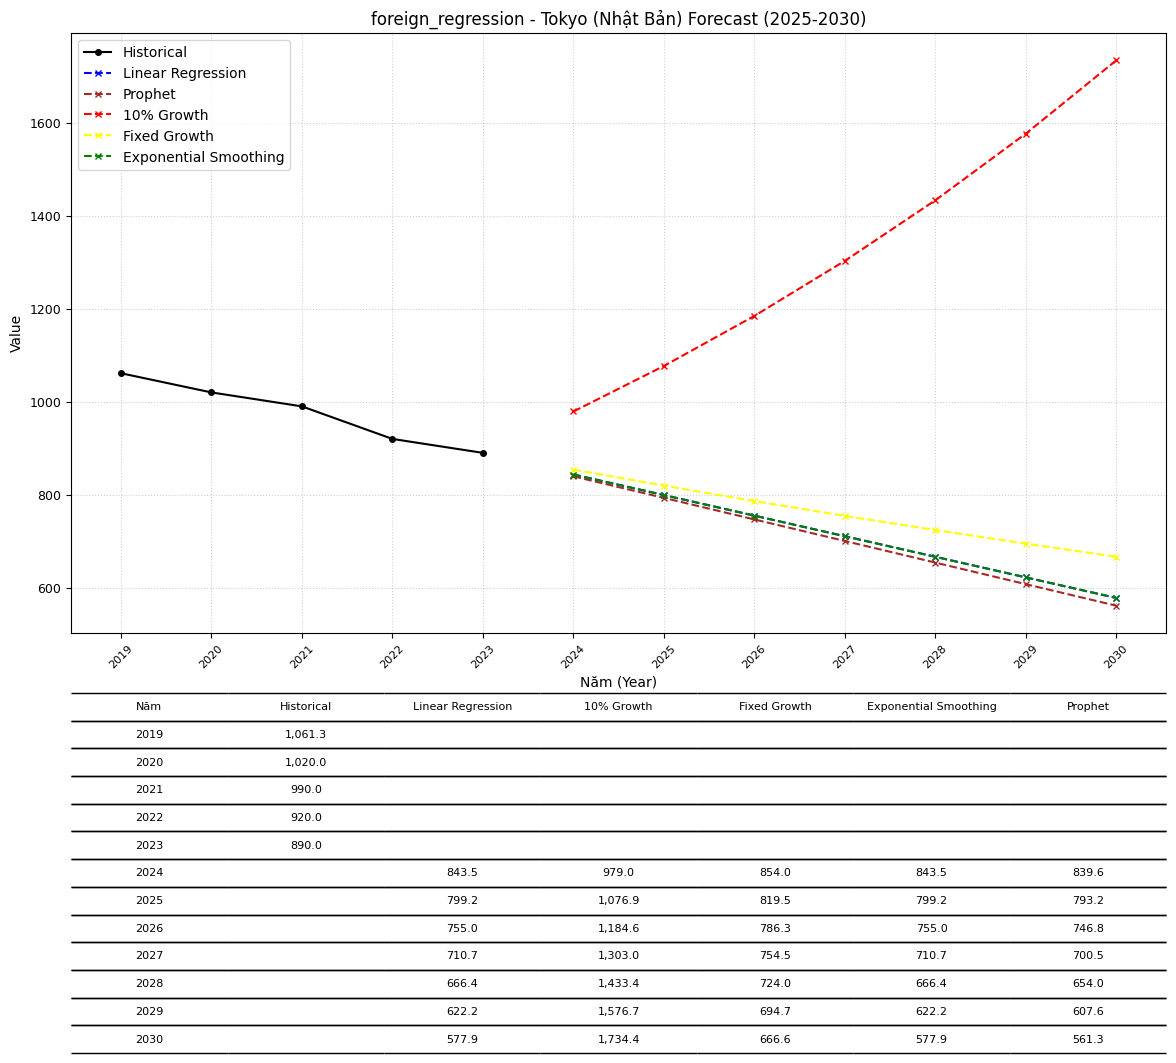

  Saved plot with table: output_plots_with_table\foreign_regression_Osaka_Nhật_Bản_with_table.png


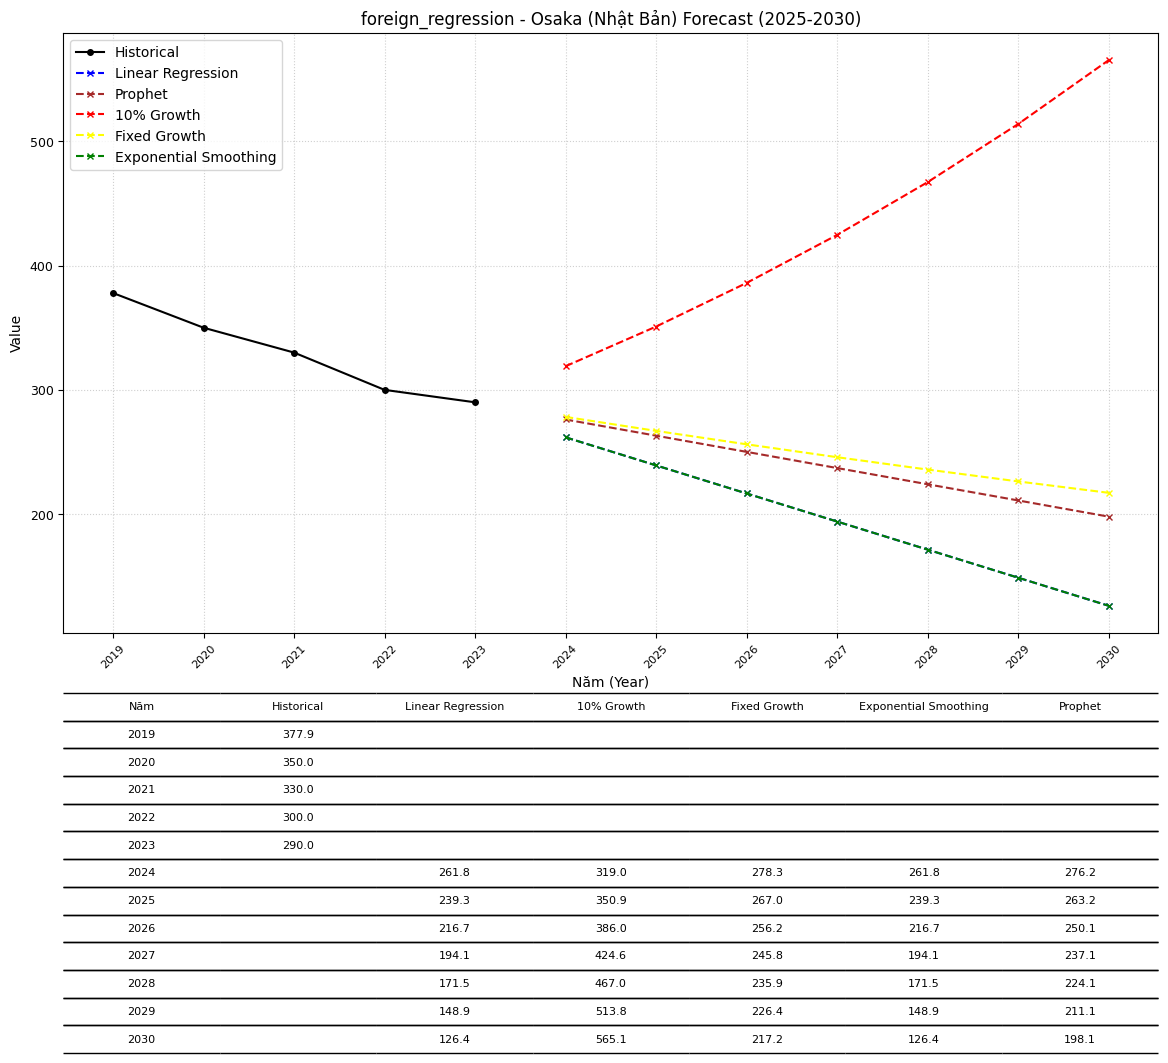

  Saved plot with table: output_plots_with_table\foreign_regression_TP_Hồ_Chí_Minh_Việt_Nam_with_table.png


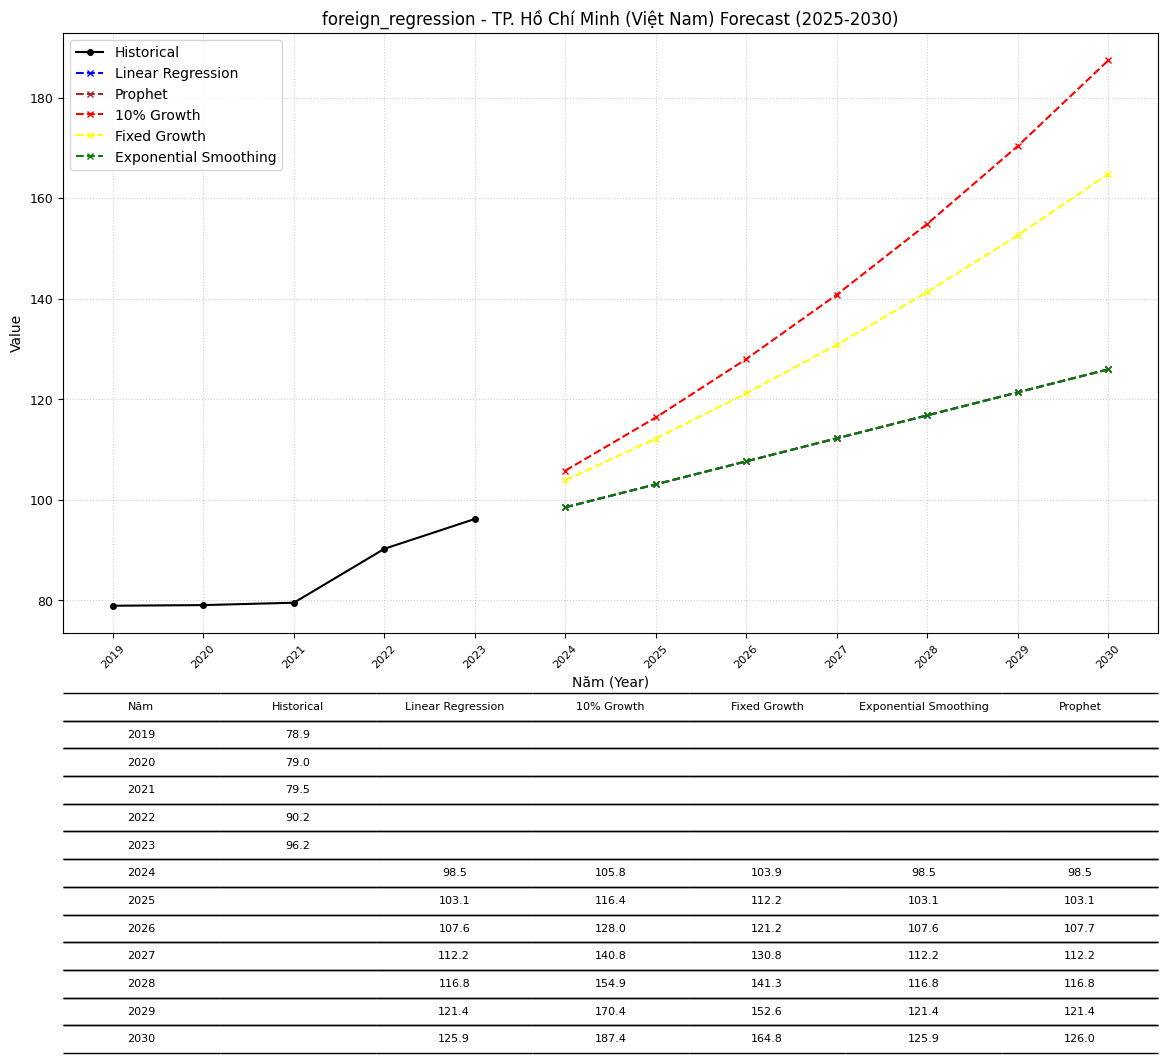


--- All visualizations with tables saved to 'output_plots_with_table' directory ---


In [310]:
for name, forecasts in all_forecasts.items():
    # Use the display name for titles/filenames
    # display_name = "Sáp nhập 3 tỉnh" if name == "Merged" else name
    display_name = "foreign_regression"
    print(f"\nProcessing plots for: {display_name}")
    historical_df = cities_grdp_df # Use original key for lookup

    for feature in features_to_forecast:
        # Check if the feature exists in both historical and forecast data
        if feature not in historical_df.columns:
             print(f"  Skipping plot for '{feature}' in '{display_name}' (historical data missing).")
             continue
        # Also check forecast data existence
        forecast_feature_exists = False
        if feature in forecasts.columns.get_level_values(0):
             forecast_feature_exists = True


        # Prepare data for the table
        hist_series = historical_df[feature].astype(float)
        table_data_list = [hist_series.rename('Historical')]

        if forecast_feature_exists:
            feature_forecasts = forecasts[feature]
            for model_name in models_for_table:
                 # Skip 'Historical' as it's already added
                 if model_name == 'Historical':
                     continue
                 if model_name in feature_forecasts.columns:
                     table_data_list.append(feature_forecasts[model_name].astype(float).rename(model_name))
                 else:
                     # Add an empty series if model forecast doesn't exist
                     table_data_list.append(pd.Series(name=model_name, dtype=float))

            # Combine all series into a DataFrame, filling NaNs for non-overlapping years
            # Only include years present in historical or any forecast
            combined_index = hist_series.index.union(feature_forecasts.index)
            table_df = pd.concat(table_data_list, axis=1).reindex(combined_index).sort_index()
            table_df.index.name = 'Năm'
            table_df = table_df.applymap(lambda x: f'{x:,.1f}' if pd.notna(x) else '') # Format numbers
            table_df = table_df.reset_index() # Make 'Năm' a column for the table function
        else:
            # If no forecast data, just format historical for the table
            print(f"  Feature '{feature}' not found in forecast data for '{display_name}'. Table will only show historical.")
            table_df = hist_series.reset_index()
            table_df.columns = ['Năm', 'Historical']
            table_df['Historical'] = table_df['Historical'].apply(lambda x: f'{x:,.1f}' if pd.notna(x) else '')


        # Start plotting
        # Adjust figsize: slightly wider, taller to give table more room
        fig, ax = plt.subplots(figsize=(15, 12)) # Use fig, ax for easier table positioning

        # --- Plotting Lines and Points (No text labels) ---
        hist_series_plot = hist_series.dropna()
        if not hist_series_plot.empty:
            ax.plot(hist_series_plot.index, hist_series_plot, label='Historical', marker='o', color=colors['Historical'], markersize=4)
            # Removed: ax.text() for historical points

        if forecast_feature_exists:
             feature_forecasts_plot = forecasts[feature]
             for model_name in feature_forecasts_plot.columns:
                 forecast_series_plot = feature_forecasts_plot[model_name].astype(float).dropna()
                 if not forecast_series_plot.empty:
                     color = colors.get(model_name, 'gray')
                     ax.plot(forecast_series_plot.index, forecast_series_plot, label=model_name, marker='x', linestyle='--', color=color, markersize=4)
                     # Removed: ax.text() for forecast points
        # --- End Plotting Lines and Points ---


        ax.set_title(f'{display_name} - {feature} Forecast (2025-2030)')
        ax.set_xlabel('Năm (Year)')
        ax.set_ylabel('Value')
        # Move legend to upper right to avoid potential overlap with steep lines
        ax.legend()
        ax.grid(True, linestyle=':', alpha=0.6)
        # Removed: ax.margins(y=0.1)

        # Adjust x-axis ticks
        all_years_indices = table_df['Năm'].tolist() # Get years from table data
        all_years = sorted(list(set(all_years_indices)))
        plt.xticks(all_years, rotation=45) # Set ticks explicitly to all years in the table
        # ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=len(all_years), integer=True)) # Alternative ticker approach
        ax.tick_params(axis='x', labelsize=8) # Smaller x-tick labels
        ax.tick_params(axis='y', labelsize=9)


        # --- Add Table ---
        if table_df is not None:
             # Adjust plot area: make bottom margin larger, top margin slightly smaller
             plt.subplots_adjust(left=0.2, bottom=0.35, right=0.93, top=0.85)

             # Filter table_df to only include relevant columns for display if needed
             display_cols = ['Năm'] + [col for col in models_for_table if col in table_df.columns]
             table_display_df = table_df[display_cols]


             # Add the table
             the_table = ax.table(cellText=table_display_df.values,
                                  colLabels=table_display_df.columns,
                                  loc='bottom', # Position table below the axes
                                  cellLoc='center',
                                  edges='horizontal',
                                  # Adjust bbox: [left, bottom, width, height]
                                  # bottom value (-0.6) pushes it further down, height (0.4) makes it taller
                                  bbox=[0.0, -0.7, 1.0, 0.6]
                                )

             the_table.auto_set_font_size(False)
             the_table.set_fontsize(8)
             the_table.scale(1, 1.1) # Adjust scale slightly
        else:
             plt.tight_layout() # Use tight layout if no table


        # Create a clean filename using display_name
        clean_feature_name = re.sub(r'[\\/*?:"<>|()]', '', feature)
        clean_feature_name = clean_feature_name.replace(' ', '_').replace('.', '')
        # Use display_name (which might contain spaces) cleaned for filename
        clean_name = display_name.replace(' ', '_')
        filename = f"{clean_name}_{clean_feature_name}_with_table.png"
        filepath = os.path.join(output_dir, filename)

        # Save the figure
        try:
             plt.savefig(filepath, dpi=150, bbox_inches='tight') # Use bbox_inches='tight' to help fit table
             print(f"  Saved plot with table: {filepath}")
        except Exception as e:
             print(f"  Error saving plot {filepath}: {e}")
        plt.show()
        plt.close(fig) # Close the figure explicitly

print(f"\n--- All visualizations with tables saved to '{output_dir}' directory ---")